# Car Classifer Notebook


## Table of Contents

1. [Packages and Helper Functions](functions)
2. [Balanced Data Set](balanced)
3. [Reduced Classes](reduced)
4. [Reduced and Balanced Classes](reducedbalanced)


## Packages and Helper Functions<a name='functions'>

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

In [13]:
import tensorflow as tf
import re

In [14]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

In [15]:
def prepare_sample(features):
    image = tf.image.resize(features["image"], size=(224, 224))
    image = tf.cast(image, tf.float32) / 255.0 
    return image, features["category_id"]


def get_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {"image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64)}
    
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = tf.image.resize(example["image"], size=(224, 224))
    label = tf.cast(example['category_id'], tf.int32)
    
    return image, label

def load_dataset(filenames, labeled=True, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO)
    
    return dataset

def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = True, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = prefetch(AUTO)
    return dataset

In [16]:
tfrecords_dir = "../input/car-image-train/train"

train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")
batch_size = 32
epochs = 30
steps_per_epoch = 50
AUTOTUNE = tf.data.AUTOTUNE

input_tensor = tf.keras.layers.Input(shape=(224, 224, 3), name="image")

In [17]:

CLASSES = ['Fiat_Seicento', 'Toyota_Picnic', 'Volkswagen_Caddy Maxi', 'Isuzu_Rodeo', 'MINI_Paceman', 'Ford_Focus', 
           'Infiniti_Q30', 'Infiniti_Q70', 'Land Rover_Range Rover Sport', 'Subaru_Legacy', 'Mazda_Bongo', 
           'Fiat_Doblo', 'Ford_C-Max', 'Mercedes-Benz_200', 'Nissan_Juke', 'Hyundai_Amica', 'Mercedes-Benz_SLC', 
           'Kia_Venga', 'Kia_Stinger', 'Lexus_LC 500', 'Honda_Elysion', 'Mercedes-Benz_GLA Class', 'Dodge_Avenger', 
           'Fiat_500', 'Ford_Ka', 'Daewoo_Nubira', 'Hyundai_i40', 'Lexus_IS 200', 'Rover_City Rover', 'Land Rover_Freelander', 
           'Jaguar_XKR', 'Toyota_Alphard', 'Ford_Cougar', 'Subaru_WRX STI', 'Infiniti_QX30', 'Ford_Fiesta', 
           'Jaguar_F-Type', 'Hyundai_i10', 'Volkswagen_Golf Plus', 'Jaguar_E-PACE', 'Hyundai_Santa Fe', 'Lexus_RC F', 
           'Mitsubishi_Shogun Pinin', 'Mercedes-Benz_CL', 'Toyota_Auris', 'Fiat_500C', 'Rover_75', 'Honda_Civic', 
           'Suzuki_Wagon R', 'MINI_Unspecified', 'Honda_Integra', 'Volkswagen_Arteon', 'Lexus_IS 300', 'Suzuki_SX4', 
           'Jeep_Wrangler', 'Nissan_Cube', 'Land Rover_Freelander', 'Mercedes-Benz_Citan', 'Volkswagen_Polo', 'Nissan_Almera', 
           'Toyota_Auris', 'Honda_FR-V', 'Toyota_Verso', 'Mazda_CX-5', 'Ford_Escort', 'Volkswagen_Touareg', 'Ford_GT', 
           'Jeep_Grand Cherokee', 'Ford_Focus C-Max', 'Kia_Sorento', 'Volkswagen_Campervan', 'Fiat_Panda', 'Subaru_Levorg', 
           'Volkswagen_California', 'Toyota_RAV4', 'Mercedes-Benz_SLC', 'Volkswagen_Caravelle', 'Hyundai_Matrix', 
           'Nissan_Almera Tino', 'Toyota_Hilux', 'Lexus_GS 250', 'Infiniti_QX30', 'Suzuki_Swift', 'Jeep_Patriot', 
           'Volkswagen_Tiguan Allspace', 'Ford_Mustang', 'Lexus_LS 460', 'Subaru_Forester', 'Lexus_IS 250', 'Mazda_BT-50', 
           'Mitsubishi_Grandis', 'MINI_Clubman', 'Volkswagen_Amarok', 'Saab_9-3', 'Fiat_Barchetta', 'Honda_Jazz', 
           'Hyundai_i800', 'Volkswagen_Bora', 'Honda_Integra', 'Ford_Maverick', 'Volkswagen_Jetta', 'MINI_Roadster', 
           'Volkswagen_Passat', 'DS_4', 'Mercedes-Benz_GLC Class', 'Volkswagen_Polo', 'Hyundai_Sonata', 'Proton_Impian', 
           'Suzuki_Grand Vitara', 'Ford_Mondeo', 'Fiat_Bravo', 'Mitsubishi_Carisma', 'Ford_Focus CC', 'Mitsubishi_Colt Cabriolet', 
           'Lexus_GS 300', 'Suzuki_Alto', 'Kia_Sedona', 'Mitsubishi_Colt Space Star', 'Suzuki_Vitara', 'Toyota_Urbancruiser', 
           'Lexus_RX', 'Toyota_GT86', 'Hyundai_Trajet', 'Infiniti_QX70', 'Mazda_323', 'Mercedes-Benz_V Class', 'Fiat_Stilo', 
           'Kia_Stonic', 'Hyundai_Terracan', 'Mercedes-Benz_A Class', 'Mercedes-Benz_S Class', 'Hyundai_Kona', 'Subaru_XV', 
           'Toyota_Avensis', 'Fiat_Multipla', 'Ford_Streetka', 'Nissan_GT-R', 'Ford_Focus C-Max', 'Toyota_Yaris Verso', 
           'Hyundai_ix20', 'Volkswagen_Sharan', 'MINI_Coupe', 'Ford_Grand C-Max', 'Daihatsu_Terios', 'Mitsubishi_Space Wagon', 
           'Honda_Element', 'Volkswagen_Golf', 'Volkswagen_Tiguan Allspace', 'Toyota_Estima', 'Toyota_GT86', 'Nissan_350 Z', 
           'Toyota_Prius+', 'Suzuki_Celerio', 'Lexus_GS 450h', 'Proton_GEN-2', 'Lexus_NX', 'Fiat_Idea', 'Mercedes-Benz_220', 
           'Ford_Edge', 'Jaguar_XK', 'Honda_Elysion', 'Mercedes-Benz_Viano', 'Fiat_Brava', 'Jaguar_F-PACE', 'Mercedes-Benz_Amg Gt', 
           'Mercedes-Benz_500', 'Land Rover_Defender 110', 'Land Rover_Range Rover', 'Lexus_NX 200t', 'Honda_S2000', 
           'Jaguar_S-Type', 'Mercedes-Benz_G Class', 'Lexus_SC 430', 'Fiat_Punto', 'Toyota_Voxy', 'Hyundai_i40', 'Mazda_Mazda6', 
           'Hyundai_Elantra', 'Honda_CR-Z', 'Kia_Cerato', 'Ford_Freda', 'Fiat_500L', 'Mercedes-Benz_SLR McLaren', 'Toyota_Yaris', 
           'MINI_Clubvan', 'Jaguar_XK8', 'Daihatsu_Copen', 'Toyota_Hilux', 'Land Rover_Discovery 4', 'Toyota_AYGO', 'Kia_Soul', 
           'DS_5', 'Lexus_RX 200t', 'Suzuki_Splash', 'Suzuki_Jimny', 'Volkswagen_Fox', 'Mercedes-Benz_C Class', 'Subaru_Justy', 
           'Mercedes-Benz_CLC Class', 'Ford_Transit Custom', 'Hyundai_Ioniq', 'Volkswagen_Scirocco', 'Infiniti_Q50', 
           'Mitsubishi_Colt', 'Fiat_124 Spider', 'Mitsubishi_Eclipse Cross', 'Infiniti_Q60', 'Jaguar_X-Type', 'Fiat_Tipo', 
           'DS_3 Cabrio', 'Lexus_IS 220d', 'Daihatsu_Materia', 'Lexus_LS 600h', 'Land Rover_Range Rover Evoque', 'Smart_forfour', 
           'Mitsubishi_Carisma', 'Mercedes-Benz_Vito', 'Honda_Accord', 'Toyota_Corolla Verso', 'Ford_Transit Connect', 'Mazda_Mazda5', 
           'Daewoo_Matiz', 'Volkswagen_T-Roc', 'Ford_Ranger', 'Kia_Optima', 'Hyundai_Kona', 'Nissan_Elgrand', 'Mercedes-Benz_CLS', 
           'MINI_Hatch', 'Ford_Grand Tourneo Connect', 'Land Rover_Freelander 2', 'Rover_25', 'Volkswagen_Tiguan', 'Lexus_RX 300', 
           'Ford_Puma', 'Honda_FR-V', 'Mercedes-Benz_CLA Class', 'Ford_Tourneo Custom', 'Hyundai_Veloster', 'Isuzu_D-Max', 
           'Honda_HR-V', 'Mazda_CX-7', 'Lexus_LS 430', 'Infiniti_QX50', 'Mercedes-Benz_GLS Class', 'Jeep_Renegade', 'Mercedes-Benz_SLK', 
           'Mazda_CX-3', 'Toyota_Verso S', 'Lexus_IS', 'MINI_Countryman', 'Ford_Galaxy', 'Fiat_Croma', 'Mercedes-Benz_Vaneo', 
           'Corvette_Stingray', 'Mercedes-Benz_Sprinter', 'Dodge_Charger', 'Kia_Magentis', 'Fiat_Sedici', 'Suzuki_SX4 S-Cross', 
           'Infiniti_EX', 'Suzuki_Vitara', 'Kia_Sorento', 'Hyundai_Getz', 'Ford_Tourneo Connect', 'Isuzu_Rodeo', 'Rover_75 Tourer', 
           'Volkswagen_Touran', 'MINI_Convertible', 'Kia_Carens', 'Lexus_RX 350', 'Jeep_Commander', 'Dodge_Nitro', 'Volkswagen_up!', 
           'Jeep_Compass', 'Land Rover_Discovery Sport', 'Smart_fortwo', 'Land Rover_Discovery 3', 'Jaguar_XK8', "Kia_Pro_Cee'd", 
           'Mercedes-Benz_A Class', 'Jaguar_XE', 'Fiat_Punto Evo', 'DS_4 Crossback', 'Tesla_Model S', 'Jeep_Compass', "Kia_Cee'd", 
           'Jaguar_XF', 'Toyota_Urbancruiser', 'Smart_Roadster', 'Hyundai_Trajet', 'Toyota_iQ', 'Mercedes-Benz_B Class', 'Daihatsu_Sirion', 
           'Toyota_MR2', 'Hyundai_Genesis', 'Daewoo_Matiz', 'Volkswagen_Arteon', 'Mercedes-Benz_E Class', 'Mercedes-Benz_SL Class', 
           'DS_3 Cabrio', 'Honda_NSX', 'Subaru_Tribeca', 'Kia_Sportage', 'Subaru_Tribeca', 'Ford_S-Max', 'TVR_Sagaris', 'Mazda_Mazda3', 
           'Mitsubishi_Shogun', 'Mazda_MX-5', 'Nissan_e-NV200', 'Toyota_Proace', 'Mercedes-Benz_350', 'Mazda_Mazda2', 'Mercedes-Benz_X Class', 
           'Land Rover_Discovery', 'Fiat_Grande Punto', 'Honda_Accord', 'Volkswagen_CC', 'Proton_Savvy', 'Saab_9-5', 'Nissan_e-NV200', 
           'Toyota_Previa', 'Infiniti_G', 'Kia_Rio', 'Infiniti_FX', 'Kia_Niro', 'Mercedes-Benz_B Class', 'Volkswagen_Eos', 'Mercedes-Benz_R Class', 
           'Mercedes-Benz_Citan Traveliner', 'Mitsubishi_Space Star', 'Hyundai_Tucson', 'Jeep_Commander', 'Volkswagen_Beetle', 'Lexus_CT', 
           'Lexus_RX 400h', 'Volkswagen_Transporter Sportline', 'Lexus_RC 300h', 'Subaru_Outback', 'Lexus_NX 300h', 'Ford_EcoSport', 
           'Volkswagen_Caddy Maxi Life', 'Mazda_BT-50', 'Toyota_Voxy', 'Mazda_Tribute', 'Mitsubishi_Shogun Sport', 'Suzuki_Jimny', 'Lexus_RC', 
           'DS_3', 'Mitsubishi_Lancer', 'Toyota_Corolla', 'Nissan_Almera Tino', 'Ford_Explorer', 'Suzuki_Ignis', 'Land Rover_Range Rover Velar', 
           'Volkswagen_Amarok', 'Mercedes-Benz_SLS', 'Mercedes-Benz_CLK', 'Fiat_500X', 'Kia_Picanto', 'Hyundai_ix35', 'Ford_Fusion', 
           'Honda_Stepwagon', 'Fiat_Qubo', 'Dodge_Caliber', 'Toyota_Land Cruiser', 'Toyota_PROACE Verso', 'Lexus_RX 450h', 'Rover_45', 
           'Mitsubishi_ASX', 'Volkswagen_Golf SV', 'Mercedes-Benz_GLE Class', 'Suzuki_Baleno', 'Mitsubishi_Mirage', 'Lexus_IS 200', 
           'Mitsubishi_L200', 'Jaguar_XF', 'Fiat_Bravo', 'Mazda_RX-8', 'Volkswagen_Transporter Shuttle', 'Ford_Kuga', 'Honda_Insight', 
           'Hyundai_Tucson', 'Hyundai_Grandeur', 'Volkswagen_Transporter', 'Kia_Cerato', 'Toyota_Prius', 'Jaguar_XJ', 'Toyota_Land Cruiser Amazon', 
           'Toyota_C-HR', 'Subaru_Impreza', 'Hyundai_i20', 'Subaru_BRZ', 'Ford_B-Max', 'Kia_Optima', 'Hyundai_Accent', 'Ford_Mustang', 'Honda_CR-Z',
           'Mercedes-Benz_M Class', 'Suzuki_Splash', 'Volkswagen_Phaeton', 'Fiat_Fullback', 'Mitsubishi_Outlander', 'Fiat_Fiorino', 
           'Lexus_CT 200h', 'Lexus_NX Unspecified', 'Daewoo_Kalos', 'Ford_Edge', 'Suzuki_Liana', 'Mazda_MX-5 RF', 'Volkswagen_Jetta', 'Lexus_CT', 'Jeep_Cherokee', 
           'Land Rover_Defender 90', 'Nissan_370 Z', 'Ford_Kuga', 'Hyundai_Coupe', 'Tesla_Model X', 'Ford_Ka+', 'Hyundai_i30', 
           'Honda_NSX', 'Mercedes-Benz_GL Class', 'Toyota_Surf', 'Hummer_H2', 'Honda_CR-V', 'Volkswagen_Caddy']


## Preliminary Model

In [ ]:
#model.summary()

In [ ]:
#model.save("EfficientNetCar.h5")


## Balanced Data Set

In [ ]:
GCS_PATH =  '../input/'
AUTO = tf.data.experimental.AUTOTUNE

val_split = 0.25
balanced_data_files = tf.io.gfile.glob(GCS_PATH + 'balancedcartrain/balanced_train/*.tfrec')
split = len(balanced_data_files) - int(len(balanced_data_files) * val_split)

BALANCED_TRAINING_FILENAMES = balanced_data_files[:split]

BALANCED_VALIDATION_FILENAMES = balanced_data_files[split:]
TEST_FILENAMES =  tf.io.gfile.glob(GCS_PATH + 'car-image-test/test/*.tfrec')

NUM_TRAINING_IMAGES = count_data_items(BALANCED_TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(BALANCED_VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

In [ ]:
model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=427
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


model.fit(
    x=get_dataset(BALANCED_TRAINING_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=2,
)

In [18]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

In [ ]:
IMAGE_SIZE = [224, 224]

pretrained_vgg_model = tf.keras.applications.vgg16.VGG16(
        weights=None,
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
#for layer in pretrained_vgg_model.layers:
 #   if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
 #       layer.trainable = True
 #   else:
 #        layer.trainable = False
    
vgg_model = tf.keras.Sequential([
    # To a base pretrained on ImageNet to extract features from images...
    pretrained_vgg_model,
    # ... attach a new head to act as a classifier.
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
pretrained_vgg_model.summary()

In [19]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=0.01)

#vgg_model.compile(
 #   optimizer=optimizer,
  #  loss = 'sparse_categorical_crossentropy',
   # metrics=['sparse_categorical_accuracy'],
#)

#vgg_model.summary()

In [ ]:

pretrained_inception_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False ,
    input_shape=[*IMAGE_SIZE, 3]
    )
for layer in pretrained_inception_model.layers:
    if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
        layer.trainable = True
    else:
        layer.trainable = False
    
inception_model = tf.keras.Sequential([
       # To a base pretrained on ImageNet to extract features from images...
    pretrained_inception_model,
        # ... attach a new head to act as a classifier.
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

inception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

inception_model.summary()

In [ ]:
inception_history = inception_model.fit(
    x=get_dataset(BALANCED_TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(BALANCED_VALIDATION_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

In [ ]:
test_dataset = get_dataset(TEST_FILENAMES, batch_size)

In [ ]:
labels = list(map(lambda x: x[1], test_dataset) )

In [ ]:
correct_labels = [item for sublist in labels for item in sublist]

In [ ]:
model_probabilities = model.predict(test_dataset)
model_predictions = np.argmax(model_probabilities, axis = -1)

In [35]:
 label_nums = range(len(CLASSES))

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [21]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15, 15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize':7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="center", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize':7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="center", rotation_mode="anchor")
    titlestring=""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment': 'right', 'verticalalignment': 'top', 'color':'#804040'})
    plt.show()
    

In [ ]:
model_f1_score = f1_score(correct_labels, model_predictions, labels=label_nums, average='macro', zero_division = 0)

model_precision = precision_score(correct_labels, model_predictions, labels=label_nums, average='macro', zero_division = 0)

model_recall = recall_score(correct_labels, model_predictions, labels=label_nums, average='macro', zero_division = 0)

model_cmat = confusion_matrix(correct_labels, model_predictions, labels=label_nums)

In [ ]:
display_confusion_matrix(model_cmat, model_f1_score,model_precision,  model_recall)

In [ ]:
pred_list = list(model_predictions)
for i in np.unique(model_predictions):
    print(i, pred_list.count(i))

In [ ]:
CLASSES[191]

### Balanced Data set Model Evaluation

## Reduced Classes

These sets have had the classes reduced to just car brand and the model is omitted

In [22]:
GCS_PATH =  '../input/'
AUTO = tf.data.experimental.AUTOTUNE

val_split = 0.20
data_files = tf.io.gfile.glob(GCS_PATH + 'carmodel/train_new_set/*.tfrec')
split = len(data_files) - int(len(data_files) * val_split)

TRAINING_FILENAMES = data_files[:split]

VALIDATION_FILENAMES = data_files[split:]
TEST_FILENAMES =  tf.io.gfile.glob(GCS_PATH + 'carmodeltest/test_new_set/*.tfrec')

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 517225 training images, 126976 validation images, 71578 test images


In [23]:

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

reduced_efficient_model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=26
)


reduced_efficient_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

#vgg_history = model.fit(
#    x=get_dataset(TRAINING_FILENAMES, batch_size),
#    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
#    epochs=epochs,
#    steps_per_epoch=steps_per_epoch,
#    callbacks=[lr_callback],
#    verbose=2
#)
#model.fit(
#    x=get_dataset(TRAINING_FILENAMES, batch_size),
#    epochs=epochs,
#    steps_per_epoch=steps_per_epoch,
#    verbose=2,
#)
efficient_history = reduced_efficient_model.fit(
    x=get_dataset(TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

2022-06-10 15:02:49.216750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:02:49.327295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:02:49.328150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:02:49.329466: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.


2022-06-10 15:02:59.575036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-10 15:03:03.498367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50/50 - 227s - loss: 3.5946 - sparse_categorical_accuracy: 0.1312 - val_loss: 2.8054 - val_sparse_categorical_accuracy: 0.1368
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008100000379979611.
50/50 - 200s - loss: 3.2295 - sparse_categorical_accuracy: 0.1863 - val_loss: 2.8567 - val_sparse_categorical_accuracy: 0.2012
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.0005060000335611404.
50/50 - 204s - loss: 3.0504 - sparse_categorical_accuracy: 0.1931 - val_loss: 2.7511 - val_sparse_categorical_accuracy: 0.2012
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.00023240000449121004.
50/50 - 198s - loss: 2.9516 - sparse_categorical_accuracy: 0.2013 - val_loss: 2.7238 - val_sparse_categorical_accuracy: 0.2012
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
50/50 - 196s - loss: 2.9298 - sparse_categorical_accuracy: 0.1881 - val_loss: 2.7233 - val_sparse_categorical_a

In [24]:
reduced_efficient_model.save("EfficientNetCarMake.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
IMAGE_SIZE = [224, 224]

pretrained_inception_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False ,
    input_shape=[*IMAGE_SIZE, 3]
    )
for layer in pretrained_inception_model.layers:
    if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
        layer.trainable = True
    else:
        layer.trainable = False
    
reduced_inception_model = tf.keras.Sequential([
       # To a base pretrained on ImageNet to extract features from images...
    pretrained_inception_model,
        # ... attach a new head to act as a classifier.
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
    ])

87924736/87910968 [==============================] - 0s 0us/step


In [26]:
reduced_inception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

reduced_inception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1024500   
_________________________________________________________________
dense_1 (Dense)              (None, 26)                13026     
Total params: 22,840,310
Trainable params: 1,037,526
Non-trainable params: 21,802,784
_________________________________________________________________


In [27]:
reduced_inception_history = reduced_inception_model.fit(
    x=get_dataset(TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
50/50 - 207s - loss: 8.1122 - sparse_categorical_accuracy: 0.1256 - val_loss: 2.7012 - val_sparse_categorical_accuracy: 0.2013
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.008009999821186066.
50/50 - 202s - loss: 2.7343 - sparse_categorical_accuracy: 0.2000 - val_loss: 2.7354 - val_sparse_categorical_accuracy: 0.2012
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.004825999994277954.
50/50 - 202s - loss: 2.6832 - sparse_categorical_accuracy: 0.2144 - val_loss: 2.6429 - val_sparse_categorical_accuracy: 0.2031
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.0019603999841213225.
50/50 - 202s - loss: 2.6443 - sparse_categorical_accuracy: 0.2150 - val_loss: 2.6197 - val_sparse_categorical_accuracy: 0.2106
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 0.0004320800052583216.
50/50 - 200s - loss:

In [28]:
reduced_inception_model.save("InceptionNetCar.h5")

### Reduced class model evaluation

In [29]:
test_dataset = get_dataset(TEST_FILENAMES, batch_size)
labels = list(map(lambda x: x[1], test_dataset) )
correct_labels = [item for sublist in labels for item in sublist]

In [30]:
CLASSES = ['DS',
 'Dodge',
 'Fiat',
 'Ford',
 'Honda',
 'Hyundai',
 'Infiniti',
 'Isuzu',
 'Jaguar',
 'Jeep',
 'Kia',
 'Land Rover',
 'Lexus',
 'MINI',
 'Mazda',
 'Mercedes-Benz',
 'Mitsubishi',
 'Nissan',
 'Rover',
 'Saab',
 'Smart',
 'Subaru',
 'Suzuki',
 'Toyota',
 'Unknown',
 'Volkswagen']

In [31]:
len(CLASSES)

26

In [ ]:
pred_list = list(reduced_inception_model_predictions)
for i in np.unique(reduced_inception_model_predictions):
    print(CLASSES[i], pred_list.count(i))
    

In [33]:
reduced_inception_model_probabilities = reduced_inception_model.predict(test_dataset)
reduced_inception_model_predictions = np.argmax(reduced_inception_model_probabilities, axis = -1)

In [36]:
reduced_inception_model_f1_score = f1_score(correct_labels, reduced_inception_model_predictions, labels=label_nums, average='macro', zero_division = 0)

reduced_inception_model_precision = precision_score(correct_labels, reduced_inception_model_predictions, labels=label_nums, average='macro', zero_division = 0)

reduced_inception_model_recall = recall_score(correct_labels, reduced_inception_model_predictions, labels=label_nums, average='macro', zero_division = 0)

reduced_inception_model_cmat = confusion_matrix(correct_labels, reduced_inception_model_predictions, labels=label_nums)

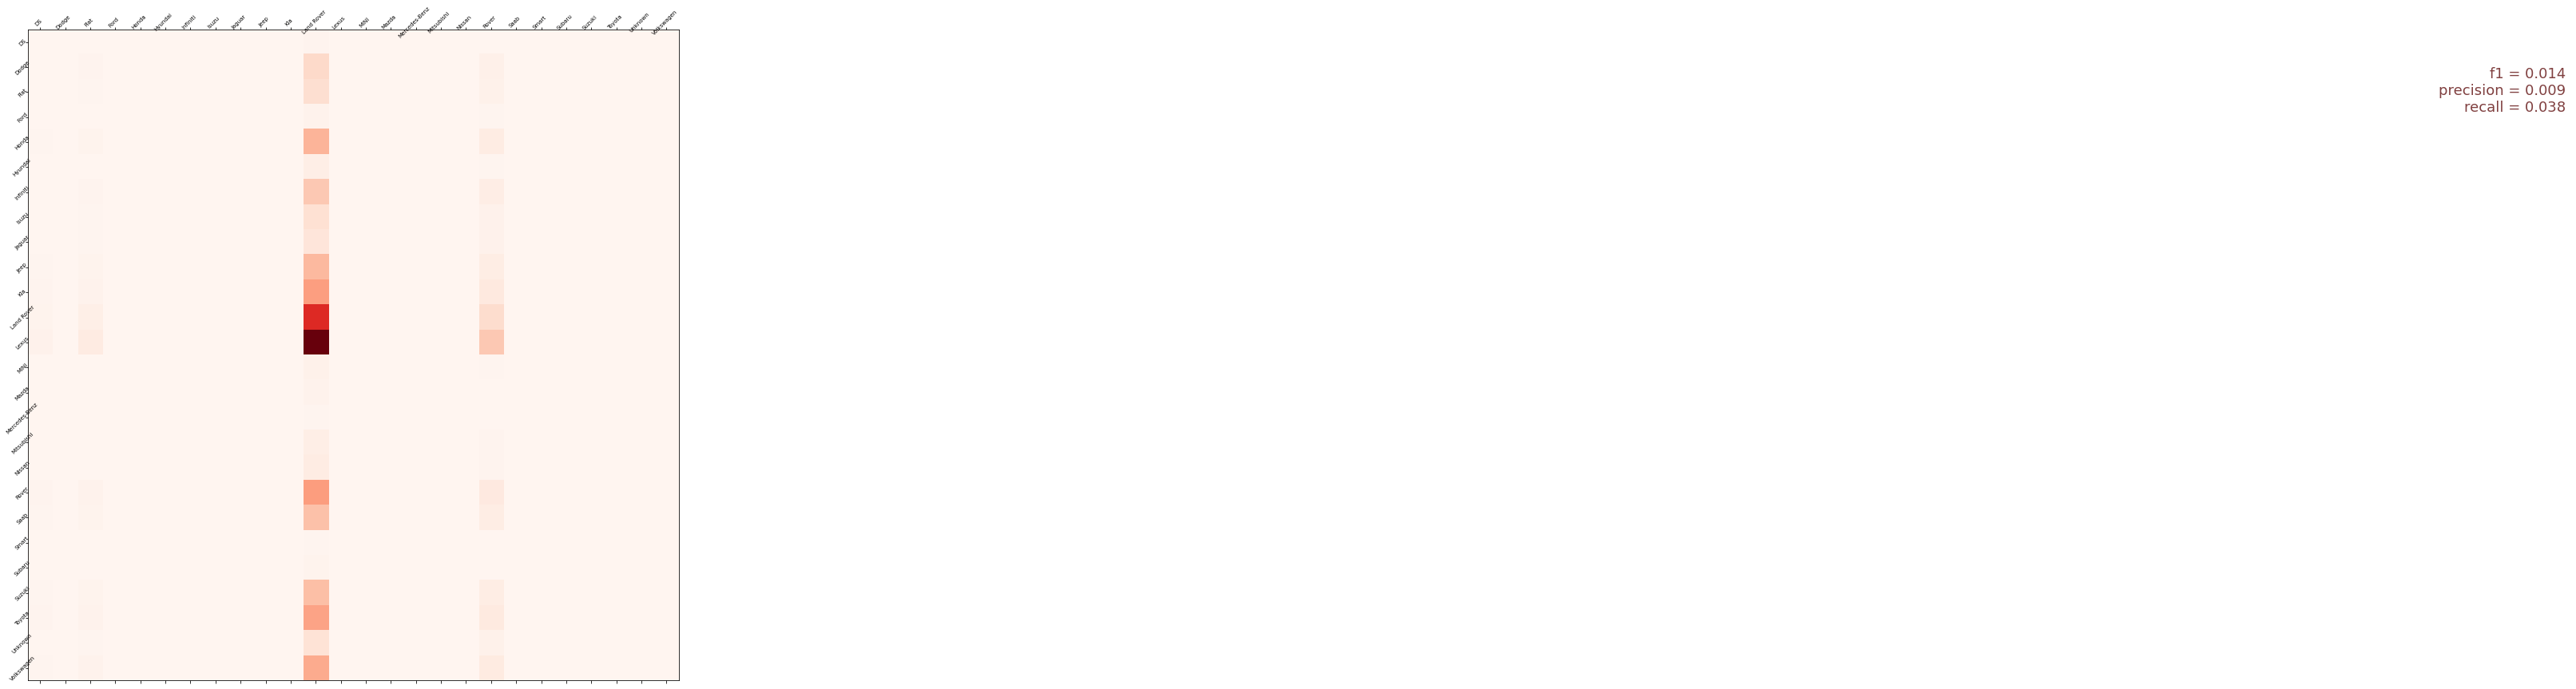

In [37]:
display_confusion_matrix(reduced_inception_model_cmat, reduced_inception_model_f1_score, reduced_inception_model_precision,  reduced_inception_model_recall)


## Reduced and Balanced Classes

In [ ]:
GCS_PATH =  '../input/'
AUTO = tf.data.experimental.AUTOTUNE

val_split = 0.25
data_files = tf.io.gfile.glob(GCS_PATH + 'balanced-reduced-train/balanced_train_reduced_classes/*.tfrec')
split = len(data_files) - int(len(data_files) * val_split)

TRAINING_FILENAMES = data_files[:split]

VALIDATION_FILENAMES = data_files[split:]
TEST_FILENAMES =  tf.io.gfile.glob(GCS_PATH + 'carmodeltest/test_new_set/*.tfrec')

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

balanced_model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=26
)


balanced_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


balanced_efficient_history = balanced_model.fit(
    x=get_dataset(TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

In [ ]:
IMAGE_SIZE = [224, 224]

pretrained_inception_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False ,
    input_shape=[*IMAGE_SIZE, 3]
    )
for layer in pretrained_inception_model.layers:
    if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
        layer.trainable = True
    else:
        layer.trainable = False
    
pretrained_inception_model = tf.keras.Sequential([
       # To a base pretrained on ImageNet to extract features from images...
    pretrained_inception_model,
        # ... attach a new head to act as a classifier.
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
    ])

In [ ]:
pretrained_inception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

pretrained_inception_model.summary()

In [ ]:
pretrained_inception_history = pretrained_inception_model.fit(
    x=get_dataset(TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

In [ ]:
pretrained_inception_model.save("InceptionNetCar2.h5")

## Test on cropped car image

In [ ]:
from PIL import Image
test_image = Image.open('../input/test-image/test_image.jpg')


In [ ]:
test_image

In [ ]:
image = np.array(test_image, dtype='uint8')

In [ ]:
image = tf.convert_to_tensor(image)


In [ ]:

image = tf.image.resize(image, size=(224, 224))
image = tf.cast(image, tf.float32) / 255.0 
image = np.expand_dims(image, axis=0)

In [ ]:
image.shape


In [ ]:
pred = pretrained_inception_model.predict(image)

In [ ]:
class_pred = np.argmax(pred) 
class_pred